In [2]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
Great! You clicked on it correctly. Now let's get started.


In [3]:
finding = 'Cardiomegaly'

In [4]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [5]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)
m = len(negatives)

In [6]:
Train_ratio = 0.8
Test_ratio = 0.2
Train_N = int(n*Train_ratio)
Test_N = int(n*Test_ratio)

In [7]:
train_label = pd.concat([positives[:Train_N], negatives[:Train_N]])
test_label = pd.concat([positives[Train_N:], negatives[Train_N:n]])

In [8]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/TRAIN/negative", exist_ok=True)
os.makedirs(rootdir+finding+"/TEST/negative", exist_ok=True)
os.makedirs(rootdir+finding+"/TEST/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/TRAIN/positive", exist_ok=True)

In [9]:
for idx, image in positives[:Train_N].iterrows():
  source = rootdir+image['filename']
  dst = rootdir+finding+"/TRAIN/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[Train_N:n].iterrows():
  source = rootdir+image['filename']
  dst = rootdir+finding+"/TEST/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:Train_N].iterrows():
  source = rootdir+image['filename']
  dst = rootdir+finding+"/TRAIN/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[Train_N:n].iterrows():
  source = rootdir+image['filename']
  dst = rootdir+finding+"/TEST/negative/"+image["filename"]
  shutil.copy(source, dst)

In [10]:
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

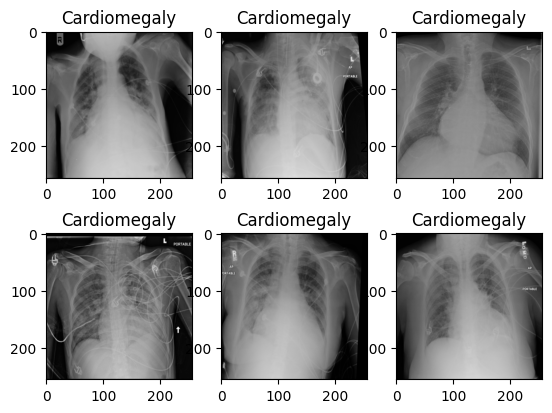

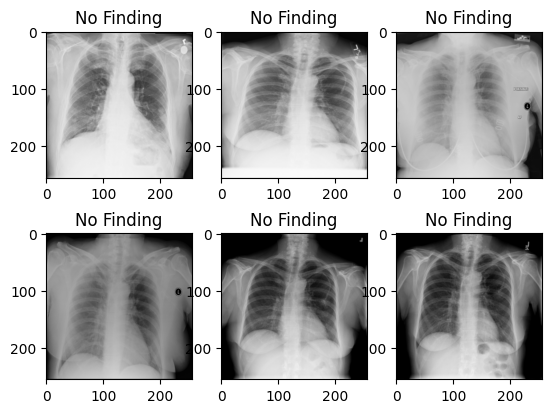

In [11]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2,3,idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2,3,idx+1)
  plt.title("No Finding")
  plt.imshow(negative_imgs[idx])
plt.show()

In [12]:
pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),   weights='imagenet', include_top=False)
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(2024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

87910968/87910968 [==============================] - 0s 0us/step


In [13]:
base_dir =  "/content/medical-ai/images"
train_dir = os.path.join(base_dir, finding, 'TRAIN')
test_dir = os.path.join(base_dir, finding, 'TEST')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')


In [14]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,

)

val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary'
)

train_steps = len(os.listdir(train_pos_dir))*2
test_steps = len(os.listdir(test_pos_dir))*2

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [16]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/20
232/232 - 29s - loss: 13.3743 - acc: 0.5431 - val_loss: 3.2440 - val_acc: 0.5667 - 29s/epoch - 125ms/step
Epoch 2/20
232/232 - 20s - loss: 4.3280 - acc: 0.5862 - val_loss: 1.1718 - val_acc: 0.6167 - 20s/epoch - 84ms/step
Epoch 3/20
232/232 - 20s - loss: 1.4652 - acc: 0.6940 - val_loss: 0.4699 - val_acc: 0.8167 - 20s/epoch - 85ms/step
Epoch 4/20
232/232 - 20s - loss: 0.8218 - acc: 0.7328 - val_loss: 0.9639 - val_acc: 0.6167 - 20s/epoch - 85ms/step
Epoch 5/20
232/232 - 19s - loss: 0.6092 - acc: 0.7328 - val_loss: 0.5484 - val_acc: 0.7500 - 19s/epoch - 84ms/step
Epoch 6/20
232/232 - 20s - loss: 0.6138 - acc: 0.6983 - val_loss: 0.4975 - val_acc: 0.7500 - 20s/epoch - 85ms/step
Epoch 7/20
232/232 - 20s - loss: 0.5431 - acc: 0.7759 - val_loss: 0.6092 - val_acc: 0.7333 - 20s/epoch - 86ms/step
Epoch 8/20
232/232 - 20s - loss: 0.5724 - acc: 0.6983 - val_loss: 0.7739 - val_acc: 0.6333 - 20s/epoch - 85ms/step
Epoch 9/20
232/232 - 19s - loss: 0.5028 - acc: 0.7500 - val_loss: 0.4377 - val

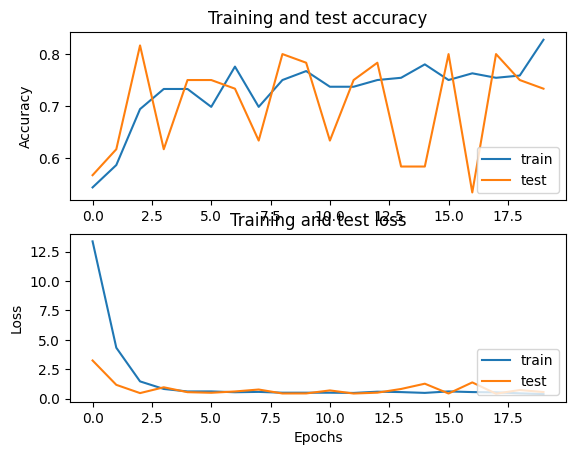

In [17]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [18]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [19]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 23ms/step
Done inference!


In [20]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/TEST/p...,00013615_052.jpg,pos,pos,0.999451
1,/content/medical-ai/images/Cardiomegaly/TEST/p...,00004893_085.jpg,pos,pos,0.998655
2,/content/medical-ai/images/Cardiomegaly/TEST/p...,00010381_000.jpg,pos,pos,0.998331
3,/content/medical-ai/images/Cardiomegaly/TEST/p...,00025969_000.jpg,pos,pos,0.997351
4,/content/medical-ai/images/Cardiomegaly/TEST/p...,00030206_013.jpg,pos,pos,0.992863


1/1 [==============================] - 0s 23ms/step


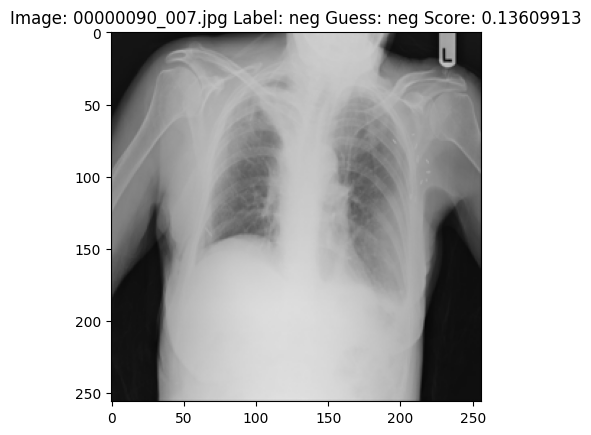

In [24]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [25]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.999451
5,00004344_013.jpg,pos,pos,0.987134
10,00001373_039.jpg,pos,pos,0.960890
15,00019187_000.jpg,pos,pos,0.930982
20,00000087_000.jpg,neg,pos,0.875354
25,00000090_002.jpg,neg,pos,0.777046
30,00000090_006.jpg,neg,pos,0.646947
35,00000080_005.jpg,neg,pos,0.564771
40,00000073_007.jpg,neg,neg,0.424361
45,00000087_001.jpg,neg,neg,0.312383


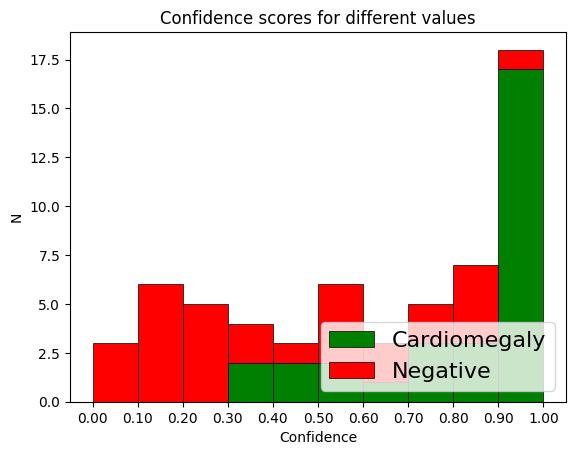

In [27]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [29]:
cutoff = 0.79 #@param {type:"slider", min:0, max:1, step:0.01}

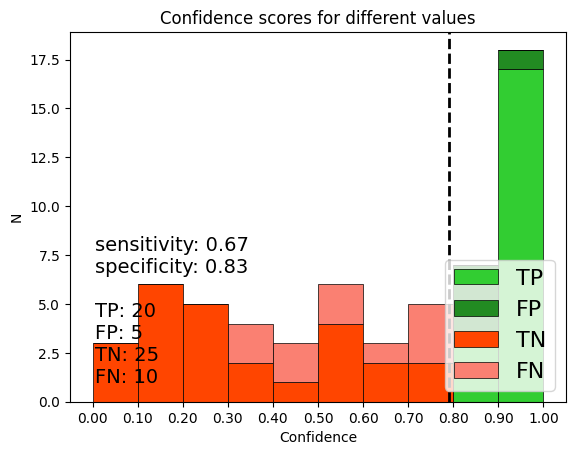

In [30]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff)

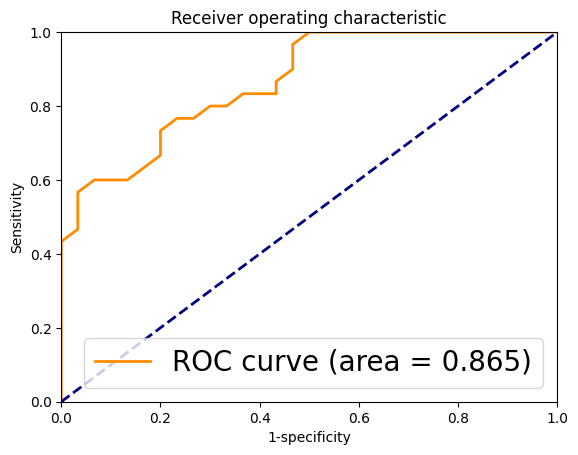

In [31]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()